In [1]:
import whitebox_workflows as wbw
import matplotlib
import os
from whitebox_workflows import download_sample_data, show
from whitebox_workflows import WbPalette

In [2]:
wbe = wbw.WbEnvironment()
wbe.version()

'Whitebox Workflows for Python v1.3.5 by Whitebox Geospatial Inc. \nDeveloped by Dr. John B. Lindsay, (c) 2022-2024\n\nDescription:\nWhitebox Workflows for Python is an advanced geospatial data analysis platform \nand Python extension module.'

In [3]:
wbe.working_directory = os.getcwd()

wbe.working_directory

'c:\\Users\\NIKHIL\\Downloads\\LiDAR\\'

In [4]:
lidar = wbe.read_lidar('lidar.laz')

In [5]:
print(f'Number of points in lidar: {lidar.header.number_of_points}')

Number of points in lidar: 39021274


In [6]:
wbe.lidar_info(lidar, output_html_file = 'lidar_info.html')

'Please see output HTML file for result.'

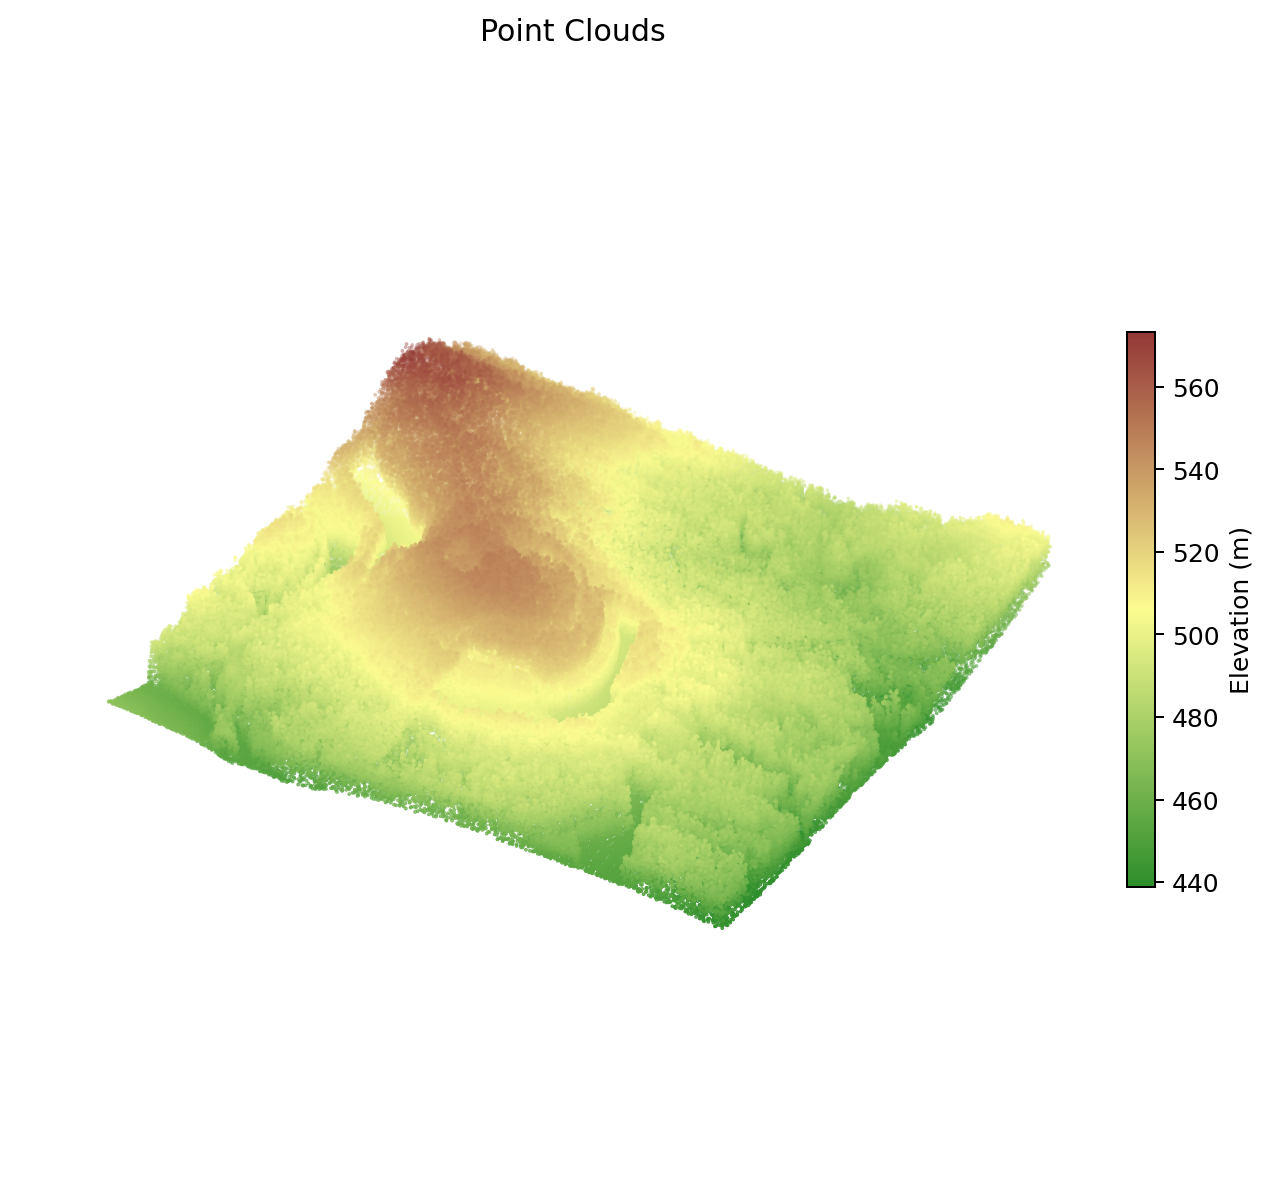

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_dpi(180.0)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_axis_off()


show(
    lidar,
    figsize = (10, 8),
    ax = ax,
    skip = 100,
    vert_exaggeration = 2.0,
    marker = 'o',
    s = 0.25,
    title = 'Point Clouds',
    cmap = WbPalette.Earthtones,
    colorbar_kwargs = {'location': 'right', 
                       'shrink': 0.5,
                       'label': 'Elevation (m)',
                       'pad': 0.0
                       }
)

plt.show()


In [37]:
dsm = wbe.lidar_tin_gridding(lidar, 
                            returns_included ='all',
                            cell_size = 1.0, 
                            excluded_classes = [2],              
)

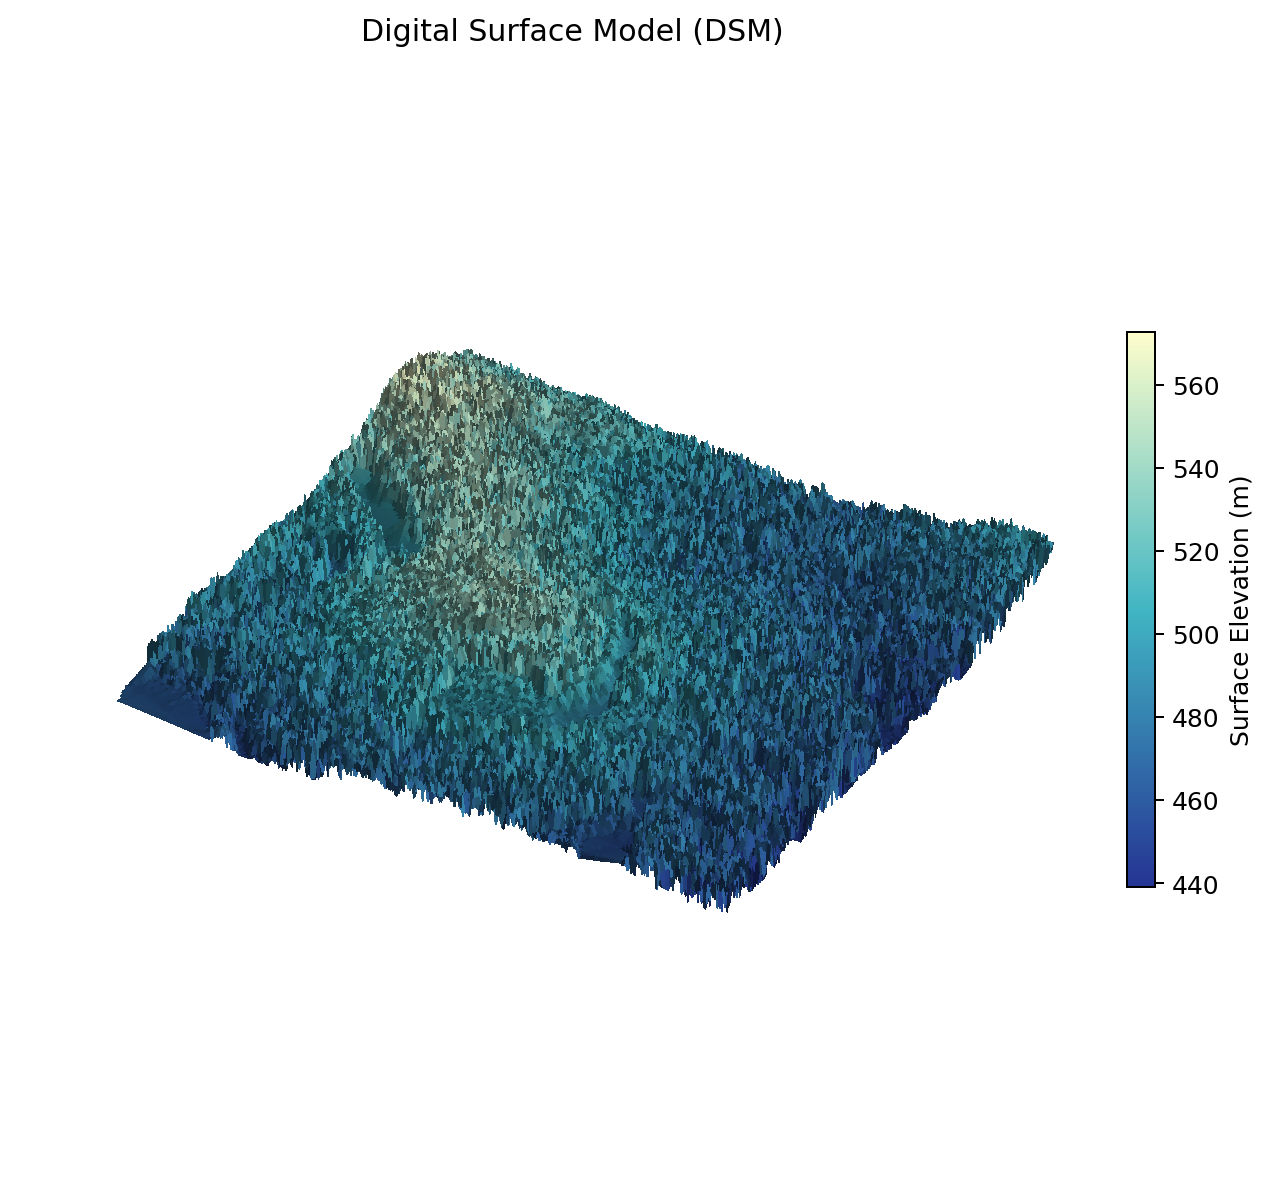

In [49]:
fig = plt.figure()
fig.set_dpi(180.0)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_axis_off()

show(
    dsm,
    figsize = (10, 8),
    ax = ax,
    skip = 2,
    plot_as_surface = True, 
    vert_exaggeration = 1.5,
    linewidth = 0.25,
    cmap = WbPalette.BlueGreenYellow,
    shade = True,
    rcount = 175,
    title = 'Digital Surface Model (DSM)',
    ccount = 175,
    antialiased = False,
    colorbar_kwargs = {'location': 'right', 
                       'shrink': 0.5,
                       'label': 'Surface Elevation (m)',
                       'pad': 0.0
                       }
)

plt.show()

In [11]:
wbe.write_raster(dsm, 'DSM.tif', compress = True)

In [40]:
dem = wbe.lidar_tin_gridding(lidar, 
                            returns_included ='all',
                            cell_size = 1.0, 
                            excluded_classes = [6, 20, 22],              
)

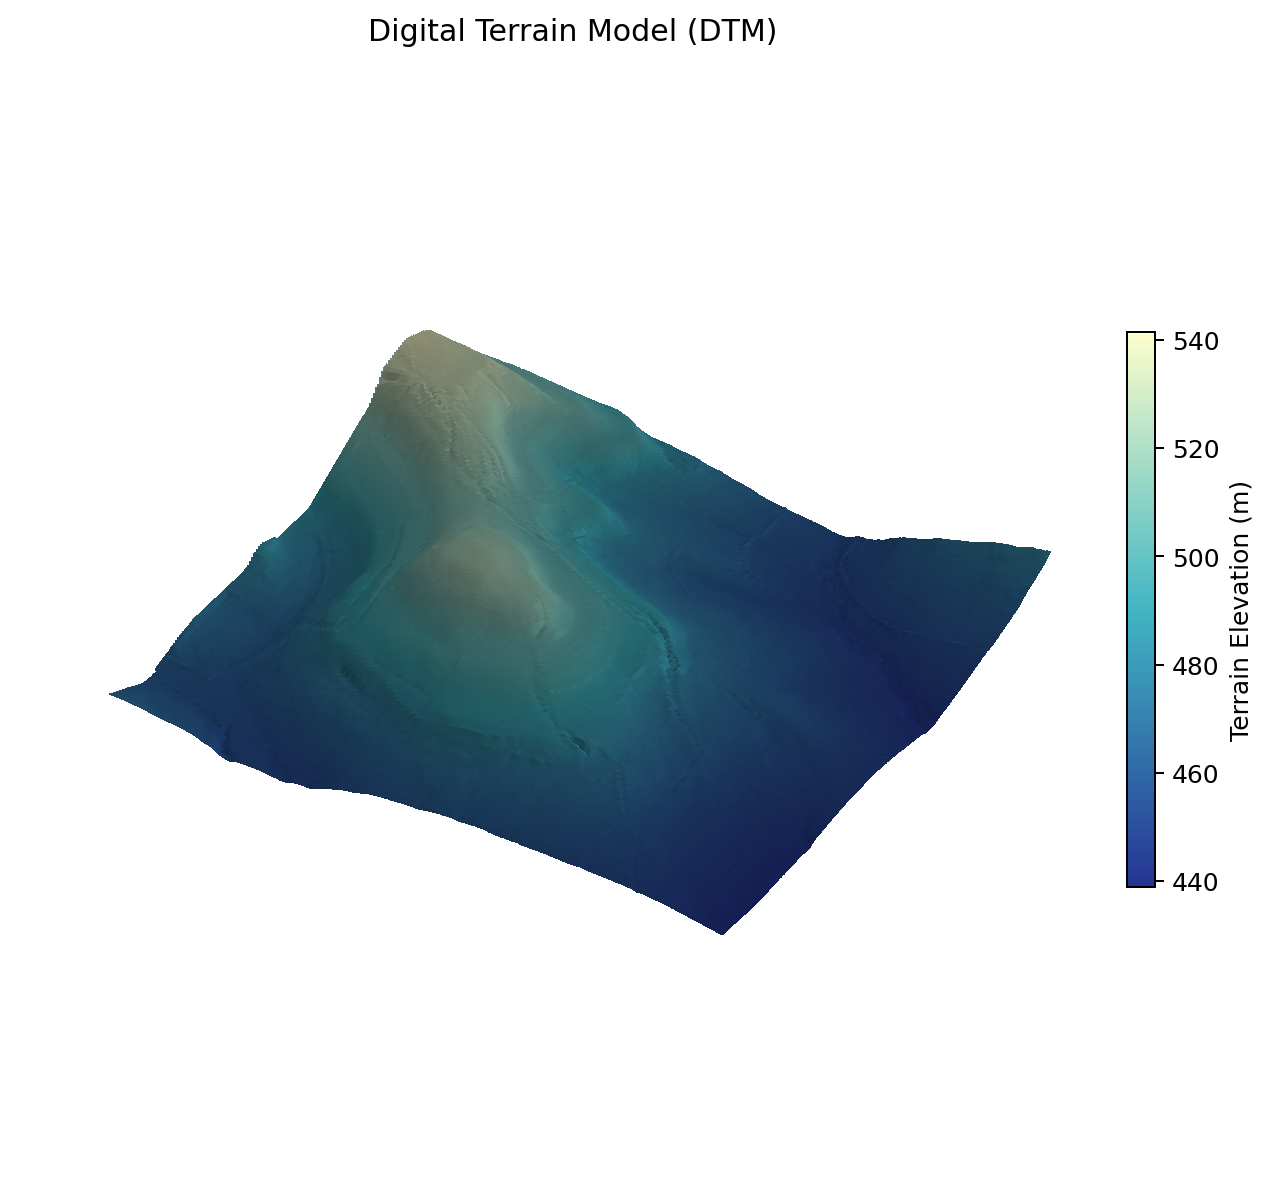

In [51]:
fig = plt.figure()
fig.set_dpi(180.0)
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_axis_off()

show(
    dem,
    figsize = (10, 8),
    ax = ax,
    skip = 2,
    plot_as_surface = True, 
    vert_exaggeration = 2.5,
    linewidth = 0.25,
    cmap = WbPalette.BlueGreenYellow,
    shade = True,
    title = 'Digital Terrain Model (DTM)',
    rcount = 175,
    ccount = 175,
    antialiased = False,
    colorbar_kwargs = {'location': 'right', 
                       'shrink': 0.5,
                       'label': 'Terrain Elevation (m)',
                       'pad': 0.0
                       }
)

plt.show()

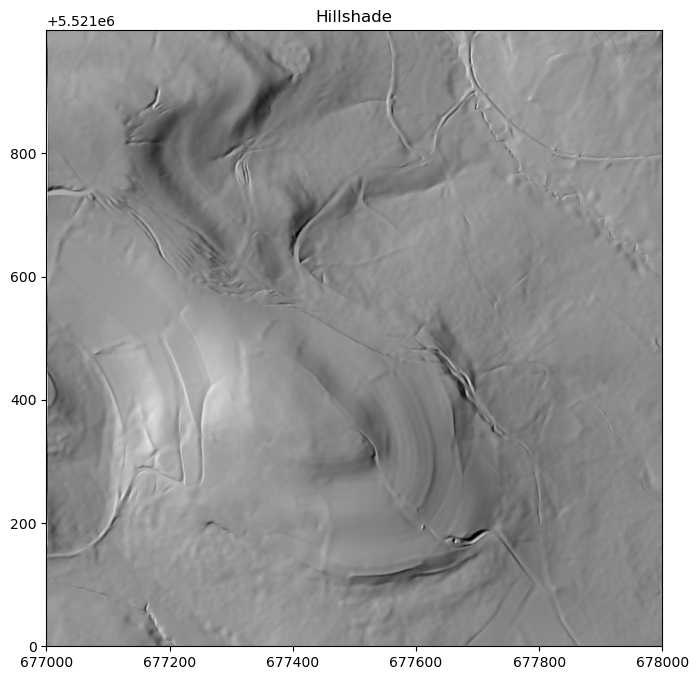

<Axes: title={'center': 'Hillshade'}>

In [17]:
smoothed = wbe.feature_preserving_smoothing(dem, filter_size = 11, 
                                            normal_diff_threshold = 25.0,
                                            iterations = 5)
hs = wbe.multidirectional_hillshade(smoothed)

show(hs, figsize = (10, 8), cmap = WbPalette.Grey, title = 'Hillshade')

In [18]:
wbe.write_raster(hs, 'hillshade.tif', compress = True)

In [19]:
contours = wbe.contours_from_raster(smoothed, contour_interval=10.0)

In [20]:
import math

dem_no_deps = wbe.breach_depressions_least_cost(
    smoothed,
    flat_increment = 0.001,
    max_dist = 100
)

dem_no_deps = wbe.fill_depressions(dem_no_deps, flat_increment = 0.001)

In [21]:
channel_threshold = 10000.0
flow_accum = wbe.qin_flow_accumulation(dem_no_deps,
                                       out_type = 'cells',
                                       convergence_threshold = channel_threshold,
                                       log_transform = True)

In [22]:
streams = flow_accum > math.log(channel_threshold)

In [23]:
d8_pntr = wbe.d8_pointer(dem_no_deps)

In [24]:
streams_vec = wbe.raster_streams_to_vector(streams, d8_pntr)
streams_vec, tmp1, tmp2, tmp3 = wbe.vector_stream_network_analysis(streams_vec, dem_no_deps)
wbe.write_vector(streams_vec, 'streams.shp')

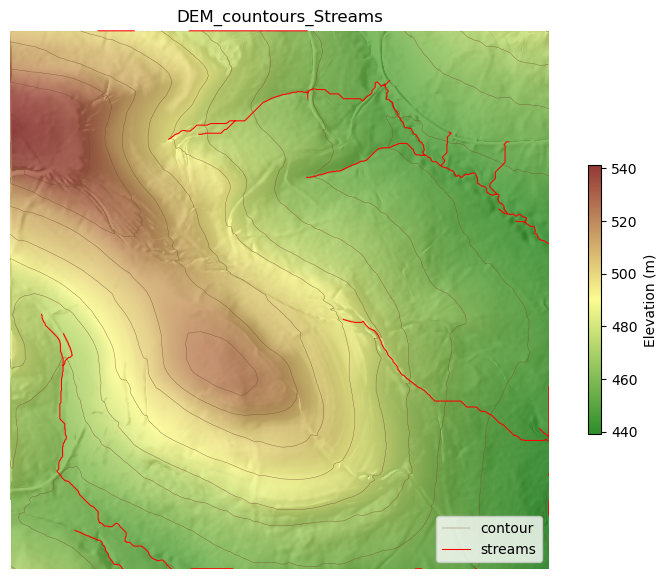

In [25]:
fig, ax = plt.subplots()

ax = show(dem, ax=ax, title='DEM_countours_Streams', cmap=WbPalette.Earthtones, figsize=(10,7), skip=2, colorbar_kwargs={'label': 'Elevation (m)', 'location': "right", 'shrink': 0.5}, zorder=1)
ax = show(hs, ax=ax, cmap='grey', clip_percent=10.0, skip=2, alpha=0.15, zorder=2)
ax = show(contours, ax=ax, color = (0.447, 0.306, 0.173), linewidth=0.25, label='contour', zorder=3)
ax = show(streams_vec, ax=ax, color ='red', linewidth=0.75, label='streams', zorder=5)

ax.set_xlim([dem.configs.west, dem.configs.east])
ax.set_ylim([dem.configs.south, dem.configs.north])

ax.legend() 
ax.set_axis_off()

plt.show()